#  NLP_ENDOPATHS_tweets

Author: Nicolai Wolpert

Email: nicolai.wolpert@capgemini.com

Date: July 2024

## Imports

In [20]:
### Imports ###

# Data manipulation and other stuff : 
import numpy as np
import pandas as pd
import re
#pd.set_option('display.max_rows', 10)
from matplotlib import pyplot as plt
import seaborn as sns
#import eli5 # eli5 not working anymore for current stable version of sklearn
from IPython.display import display

from preprocess_NLP import from_X_split_get_Y_split
from sklearn.utils import resample, shuffle

# Utils for NLP : 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Utils for Multilabel classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, hamming_loss, accuracy_score, jaccard_score, classification_report, roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import *

from sklearn.tree import plot_tree

# Multiclass/Multilabel preparation :
from sklearn.base import BaseEstimator, ClassifierMixin

# Kfold cross-validation with stratification
from Opti_utils.ML_utils import kfold_cv_stratified

# Custom preprocessing : 
from preprocess_NLP import preprocess_and_split

# Tensorflow/keras
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

from pprint import pprint
import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

import plotly.express as px
from tqdm.notebook import tqdm

from datasets.dataset_dict import DatasetDict
from datasets import Dataset

import pickle

In [21]:
data_dir = '../../Data/Tweets/'
model_dir = '../../models/'
pred_dir = '../../predictions/'

# Choose pretrained model to use (e.g. 'camembert-base' or 'camembert/camembert-large')
pretrained_model = 'camembert-base'

## Load data

In [22]:
data = pd.read_csv(data_dir + 'french_tweets.csv')
data

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."
...,...,...
1526719,1,"Oui, cela fonctionne mieux que de l'attendre à..."
1526720,1,Je viens de me réveiller. Ne pas avoir d'école...
1526721,1,Thewdb.com - très cool d'entendre les vieilles...
1526722,1,Êtes-vous prêt pour votre mojo makeover? Deman...


In [23]:
# Reduce number of data, else takes too long also choose class proportions for simulation

nsamples_to_keep = 1000
prop_neg = 0.5
prop_pos = 1 - prop_neg
nsamples_neg = int(nsamples_to_keep * prop_neg)
nsamples_pos = int(nsamples_to_keep * prop_pos)

data_neg = data.loc[data.label==0].head(nsamples_neg)
data_pos = data.loc[data.label==1].head(nsamples_pos)
data = pd.concat([data_neg, data_pos])
data

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."
...,...,...
772099,1,Commodité De la réparation & lt; --- c'est jus...
772100,1,Karaoké avec xt sur les cours de mien et de ba...
772101,1,Tapez-le sur la publication du blog et imprime...
772102,1,obi et Hornbach. (Via twitter.com): Obi et Hor...


### Camembert model accepts sentences with a maximum length of 512/514... check lengths of our sentences

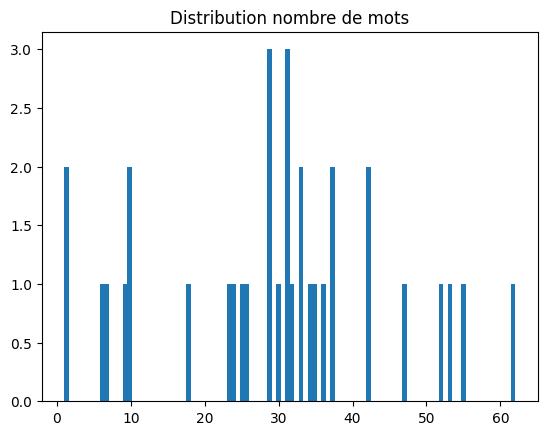

In [24]:
nwords = data['text'].str.split().apply(len).value_counts()
plt.figure()
plt.hist(nwords, bins=100)
plt.title('Distribution nombre de mots')
plt.show()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


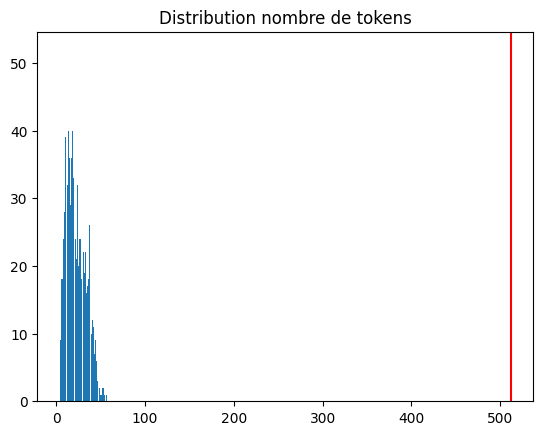

In [25]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, use_fast = False)
tokenized_data = tokenizer(data['text'].tolist())
tokenized_data
ntokens = [len(tokenized_data['input_ids'][i]) for i in range(len(tokenized_data['input_ids']))]
plt.figure()
plt.hist(ntokens, bins=100)
plt.axvline(x=512, color='red')
plt.title('Distribution nombre de tokens')
plt.show()

In [26]:
# Format labels
def label_outcome(row):
    if row['label'] == 0:
        return 'negative'
    elif row['label'] == 1:
        return 'positive'
data['str_label'] = data.apply(label_outcome, axis=1)

In [27]:
data

,label,text,str_label
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi...",negative
1,0,Est contrarié qu'il ne puisse pas mettre à jou...,negative
2,0,J'ai plongé plusieurs fois pour la balle. A ré...,negative
3,0,Tout mon corps a des démangeaisons et comme si...,negative
4,0,"Non, il ne se comporte pas du tout. je suis en...",negative
...,...,...,...
772099,1,Commodité De la réparation & lt; --- c'est jus...,positive
772100,1,Karaoké avec xt sur les cours de mien et de ba...,positive
772101,1,Tapez-le sur la publication du blog et imprime...,positive
772102,1,obi et Hornbach. (Via twitter.com): Obi et Hor...,positive


## Data preparation for training

In [28]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, use_fast = False)

def tokenize_batch(samples, tokenizer, max_length):
    text = [sample["text"] for sample in samples]
    labels = torch.tensor([sample["label"] for sample in samples])
    str_labels = [sample["str_label"] for sample in samples]
    # The tokenizer handles
    # - Tokenization (amazing right?)
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    #tokens = tokenizer(text, padding="longest", return_tensors="pt")
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    
    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Train/Val/Test split

In [29]:
prop_train = 0.8
prop_val = 0.1
prop_test = 0.1

train, test = train_test_split(data, random_state=42, test_size=prop_test, stratify=data['label'])
train, val = train_test_split(train, random_state=42, test_size=0.125, stratify=train['label'])

print(f'Number of samples in train set: {train.shape[0]}, = {round((train.shape[0]/data.shape[0])*100, 2)} %')
print(f'Number of samples in validation set: {val.shape[0]}, = {round((val.shape[0]/data.shape[0])*100, 2)} %')
print(f'Number of samples in test set: {test.shape[0]}, = {round((test.shape[0]/data.shape[0])*100, 2)} %')

Number of samples in train set: 787, = 78.7 %
Number of samples in validation set: 113, = 11.3 %
Number of samples in test set: 100, = 10.0 %


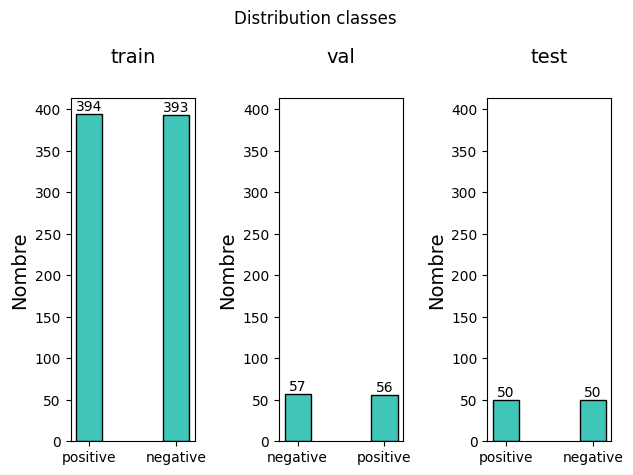

In [30]:
# Vérifier bonne distribution des classes dans train/val/test
fig, axs = plt.subplots(nrows=1, ncols=3)
axs = axs.flatten()
sns.histplot(data=train['str_label'], shrink=0.3, color='#00B2A2', ax=axs[0])
axs[0].bar_label(axs[0].containers[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('Nombre', fontsize=14)
axs[0].set_title('train', pad=25, fontsize=14)
sns.histplot(data=val['str_label'], shrink=0.3, color='#00B2A2', ax=axs[1])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_xlabel('')
axs[1].set_ylabel('Nombre', fontsize=14)
axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_title('val', pad=25, fontsize=14)
sns.histplot(data=test['str_label'], shrink=0.3, color='#00B2A2', ax=axs[2])
axs[2].bar_label(axs[2].containers[0])
axs[2].set_xlabel('')
axs[2].set_ylabel('Nombre', fontsize=14)
axs[2].set_ylim(axs[0].get_ylim())
axs[2].set_title('test', pad=25, fontsize=14)
plt.suptitle('Distribution classes')
plt.tight_layout()
plt.show()

In [31]:
# Transformer les données en format qui peut être lu dans les librairies 'HuggingFace'

max_length = 512

train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

train_dataloader = DataLoader(
    dataset["train"], 
    batch_size=16, 
    shuffle=True, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer, max_length=max_length)
)
val_dataloader = DataLoader(
    dataset["validation"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer, max_length=max_length)
)
test_dataloader = DataLoader(
    dataset["validation"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer, max_length=max_length)
)

## Training

In [32]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [33]:
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

# Set up CSV logger
csv_logger = CSVLogger("logs", name="camembert_training")
camembert_trainer = pl.Trainer(
    max_epochs=20,
    #gpus=1,
    logger=csv_logger,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [34]:
learning_rate = 3e-5
lightning_model = LightningModel(pretrained_model, num_labels=2, lr=learning_rate, weight_decay=0.)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


  | Name  | Type                               | Params | Mode
--------------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M  | eval
--------------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.494   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in th

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
pickle.dump(camembert_trainer, open(model_dir + f'{pretrained_model}_sliding_window_learning_rate_{learning_rate}_tweets', 'wb'))

In [ ]:
camembert_trainer = pickle.load(open(model_dir + f'{pretrained_model}_sliding_window_learning_rate_{learning_rate}_tweets', 'rb'))

EOFError: Ran out of input

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the best model checkpoint
best_model_path = model_checkpoint.best_model_path
best_model = LightningModel.load_from_checkpoint(best_model_path, model_name='camembert/camembert-large', num_labels=2, lr=3e-5, weight_decay=0.)

# Predict on the test dataset
predictions = []
true_labels = []

best_model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculations for inference
    for batch in test_dataloader:
        preds = best_model.predict_step(batch, batch_idx=0).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        
        predictions.extend(preds)
        true_labels.extend(labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.embeddings.word_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Error(s) in loading state_dict for LightningModel:
	Missing key(s) in state_dict: "model.roberta.encoder.layer.12.attention.self.query.weight", "model.roberta.encoder.layer.12.attention.self.query.bias", "model.roberta.encoder.layer.12.attention.self.key.weight", "model.roberta.encoder.layer.12.attention.self.key.bias", "model.roberta.encoder.layer.12.attention.self.value.weight", "model.roberta.encoder.layer.12.attention.self.value.bias", "model.roberta.encoder.layer.12.attention.output.dense.weight", "model.roberta.encoder.layer.12.attention.output.dense.bias", "model.roberta.encoder.layer.12.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.12.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.12.intermediate.dense.weight", "model.roberta.encoder.layer.12.intermediate.dense.bias", "model.roberta.encoder.layer.12.output.dense.weight", "model.roberta.encoder.layer.12.output.dense.bias", "model.roberta.encoder.layer.12.output.LayerNorm.weight", "model.roberta.encoder.layer.12.output.LayerNorm.bias", "model.roberta.encoder.layer.13.attention.self.query.weight", "model.roberta.encoder.layer.13.attention.self.query.bias", "model.roberta.encoder.layer.13.attention.self.key.weight", "model.roberta.encoder.layer.13.attention.self.key.bias", "model.roberta.encoder.layer.13.attention.self.value.weight", "model.roberta.encoder.layer.13.attention.self.value.bias", "model.roberta.encoder.layer.13.attention.output.dense.weight", "model.roberta.encoder.layer.13.attention.output.dense.bias", "model.roberta.encoder.layer.13.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.13.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.13.intermediate.dense.weight", "model.roberta.encoder.layer.13.intermediate.dense.bias", "model.roberta.encoder.layer.13.output.dense.weight", "model.roberta.encoder.layer.13.output.dense.bias", "model.roberta.encoder.layer.13.output.LayerNorm.weight", "model.roberta.encoder.layer.13.output.LayerNorm.bias", "model.roberta.encoder.layer.14.attention.self.query.weight", "model.roberta.encoder.layer.14.attention.self.query.bias", "model.roberta.encoder.layer.14.attention.self.key.weight", "model.roberta.encoder.layer.14.attention.self.key.bias", "model.roberta.encoder.layer.14.attention.self.value.weight", "model.roberta.encoder.layer.14.attention.self.value.bias", "model.roberta.encoder.layer.14.attention.output.dense.weight", "model.roberta.encoder.layer.14.attention.output.dense.bias", "model.roberta.encoder.layer.14.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.14.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.14.intermediate.dense.weight", "model.roberta.encoder.layer.14.intermediate.dense.bias", "model.roberta.encoder.layer.14.output.dense.weight", "model.roberta.encoder.layer.14.output.dense.bias", "model.roberta.encoder.layer.14.output.LayerNorm.weight", "model.roberta.encoder.layer.14.output.LayerNorm.bias", "model.roberta.encoder.layer.15.attention.self.query.weight", "model.roberta.encoder.layer.15.attention.self.query.bias", "model.roberta.encoder.layer.15.attention.self.key.weight", "model.roberta.encoder.layer.15.attention.self.key.bias", "model.roberta.encoder.layer.15.attention.self.value.weight", "model.roberta.encoder.layer.15.attention.self.value.bias", "model.roberta.encoder.layer.15.attention.output.dense.weight", "model.roberta.encoder.layer.15.attention.output.dense.bias", "model.roberta.encoder.layer.15.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.15.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.15.intermediate.dense.weight", "model.roberta.encoder.layer.15.intermediate.dense.bias", "model.roberta.encoder.layer.15.output.dense.weight", "model.roberta.encoder.layer.15.output.dense.bias", "model.roberta.encoder.layer.15.output.LayerNorm.weight", "model.roberta.encoder.layer.15.output.LayerNorm.bias", "model.roberta.encoder.layer.16.attention.self.query.weight", "model.roberta.encoder.layer.16.attention.self.query.bias", "model.roberta.encoder.layer.16.attention.self.key.weight", "model.roberta.encoder.layer.16.attention.self.key.bias", "model.roberta.encoder.layer.16.attention.self.value.weight", "model.roberta.encoder.layer.16.attention.self.value.bias", "model.roberta.encoder.layer.16.attention.output.dense.weight", "model.roberta.encoder.layer.16.attention.output.dense.bias", "model.roberta.encoder.layer.16.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.16.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.16.intermediate.dense.weight", "model.roberta.encoder.layer.16.intermediate.dense.bias", "model.roberta.encoder.layer.16.output.dense.weight", "model.roberta.encoder.layer.16.output.dense.bias", "model.roberta.encoder.layer.16.output.LayerNorm.weight", "model.roberta.encoder.layer.16.output.LayerNorm.bias", "model.roberta.encoder.layer.17.attention.self.query.weight", "model.roberta.encoder.layer.17.attention.self.query.bias", "model.roberta.encoder.layer.17.attention.self.key.weight", "model.roberta.encoder.layer.17.attention.self.key.bias", "model.roberta.encoder.layer.17.attention.self.value.weight", "model.roberta.encoder.layer.17.attention.self.value.bias", "model.roberta.encoder.layer.17.attention.output.dense.weight", "model.roberta.encoder.layer.17.attention.output.dense.bias", "model.roberta.encoder.layer.17.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.17.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.17.intermediate.dense.weight", "model.roberta.encoder.layer.17.intermediate.dense.bias", "model.roberta.encoder.layer.17.output.dense.weight", "model.roberta.encoder.layer.17.output.dense.bias", "model.roberta.encoder.layer.17.output.LayerNorm.weight", "model.roberta.encoder.layer.17.output.LayerNorm.bias", "model.roberta.encoder.layer.18.attention.self.query.weight", "model.roberta.encoder.layer.18.attention.self.query.bias", "model.roberta.encoder.layer.18.attention.self.key.weight", "model.roberta.encoder.layer.18.attention.self.key.bias", "model.roberta.encoder.layer.18.attention.self.value.weight", "model.roberta.encoder.layer.18.attention.self.value.bias", "model.roberta.encoder.layer.18.attention.output.dense.weight", "model.roberta.encoder.layer.18.attention.output.dense.bias", "model.roberta.encoder.layer.18.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.18.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.18.intermediate.dense.weight", "model.roberta.encoder.layer.18.intermediate.dense.bias", "model.roberta.encoder.layer.18.output.dense.weight", "model.roberta.encoder.layer.18.output.dense.bias", "model.roberta.encoder.layer.18.output.LayerNorm.weight", "model.roberta.encoder.layer.18.output.LayerNorm.bias", "model.roberta.encoder.layer.19.attention.self.query.weight", "model.roberta.encoder.layer.19.attention.self.query.bias", "model.roberta.encoder.layer.19.attention.self.key.weight", "model.roberta.encoder.layer.19.attention.self.key.bias", "model.roberta.encoder.layer.19.attention.self.value.weight", "model.roberta.encoder.layer.19.attention.self.value.bias", "model.roberta.encoder.layer.19.attention.output.dense.weight", "model.roberta.encoder.layer.19.attention.output.dense.bias", "model.roberta.encoder.layer.19.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.19.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.19.intermediate.dense.weight", "model.roberta.encoder.layer.19.intermediate.dense.bias", "model.roberta.encoder.layer.19.output.dense.weight", "model.roberta.encoder.layer.19.output.dense.bias", "model.roberta.encoder.layer.19.output.LayerNorm.weight", "model.roberta.encoder.layer.19.output.LayerNorm.bias", "model.roberta.encoder.layer.20.attention.self.query.weight", "model.roberta.encoder.layer.20.attention.self.query.bias", "model.roberta.encoder.layer.20.attention.self.key.weight", "model.roberta.encoder.layer.20.attention.self.key.bias", "model.roberta.encoder.layer.20.attention.self.value.weight", "model.roberta.encoder.layer.20.attention.self.value.bias", "model.roberta.encoder.layer.20.attention.output.dense.weight", "model.roberta.encoder.layer.20.attention.output.dense.bias", "model.roberta.encoder.layer.20.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.20.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.20.intermediate.dense.weight", "model.roberta.encoder.layer.20.intermediate.dense.bias", "model.roberta.encoder.layer.20.output.dense.weight", "model.roberta.encoder.layer.20.output.dense.bias", "model.roberta.encoder.layer.20.output.LayerNorm.weight", "model.roberta.encoder.layer.20.output.LayerNorm.bias", "model.roberta.encoder.layer.21.attention.self.query.weight", "model.roberta.encoder.layer.21.attention.self.query.bias", "model.roberta.encoder.layer.21.attention.self.key.weight", "model.roberta.encoder.layer.21.attention.self.key.bias", "model.roberta.encoder.layer.21.attention.self.value.weight", "model.roberta.encoder.layer.21.attention.self.value.bias", "model.roberta.encoder.layer.21.attention.output.dense.weight", "model.roberta.encoder.layer.21.attention.output.dense.bias", "model.roberta.encoder.layer.21.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.21.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.21.intermediate.dense.weight", "model.roberta.encoder.layer.21.intermediate.dense.bias", "model.roberta.encoder.layer.21.output.dense.weight", "model.roberta.encoder.layer.21.output.dense.bias", "model.roberta.encoder.layer.21.output.LayerNorm.weight", "model.roberta.encoder.layer.21.output.LayerNorm.bias", "model.roberta.encoder.layer.22.attention.self.query.weight", "model.roberta.encoder.layer.22.attention.self.query.bias", "model.roberta.encoder.layer.22.attention.self.key.weight", "model.roberta.encoder.layer.22.attention.self.key.bias", "model.roberta.encoder.layer.22.attention.self.value.weight", "model.roberta.encoder.layer.22.attention.self.value.bias", "model.roberta.encoder.layer.22.attention.output.dense.weight", "model.roberta.encoder.layer.22.attention.output.dense.bias", "model.roberta.encoder.layer.22.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.22.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.22.intermediate.dense.weight", "model.roberta.encoder.layer.22.intermediate.dense.bias", "model.roberta.encoder.layer.22.output.dense.weight", "model.roberta.encoder.layer.22.output.dense.bias", "model.roberta.encoder.layer.22.output.LayerNorm.weight", "model.roberta.encoder.layer.22.output.LayerNorm.bias", "model.roberta.encoder.layer.23.attention.self.query.weight", "model.roberta.encoder.layer.23.attention.self.query.bias", "model.roberta.encoder.layer.23.attention.self.key.weight", "model.roberta.encoder.layer.23.attention.self.key.bias", "model.roberta.encoder.layer.23.attention.self.value.weight", "model.roberta.encoder.layer.23.attention.self.value.bias", "model.roberta.encoder.layer.23.attention.output.dense.weight", "model.roberta.encoder.layer.23.attention.output.dense.bias", "model.roberta.encoder.layer.23.attention.output.LayerNorm.weight", "model.roberta.encoder.layer.23.attention.output.LayerNorm.bias", "model.roberta.encoder.layer.23.intermediate.dense.weight", "model.roberta.encoder.layer.23.intermediate.dense.bias", "model.roberta.encoder.layer.23.output.dense.weight", "model.roberta.encoder.layer.23.output.dense.bias", "model.roberta.encoder.layer.23.output.LayerNorm.weight", "model.roberta.encoder.layer.23.output.LayerNorm.bias". 
	size mismatch for model.roberta.embeddings.word_embeddings.weight: copying a param with shape torch.Size([32005, 768]) from checkpoint, the shape in current model is torch.Size([32005, 1024]).
	size mismatch for model.roberta.embeddings.position_embeddings.weight: copying a param with shape torch.Size([514, 768]) from checkpoint, the shape in current model is torch.Size([514, 1024]).
	size mismatch for model.roberta.embeddings.token_type_embeddings.weight: copying a param with shape torch.Size([1, 768]) from checkpoint, the shape in current model is torch.Size([1, 1024]).
	size mismatch for model.roberta.embeddings.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.embeddings.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.0.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.0.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.0.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.0.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.0.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.0.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.0.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.0.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.0.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.0.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.0.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.0.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.0.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.0.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.0.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.0.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.1.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.1.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.1.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.1.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.1.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.1.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.1.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.1.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.1.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.1.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.1.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.1.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.1.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.1.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.1.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.1.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.2.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.2.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.2.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.2.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.2.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.2.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.2.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.2.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.2.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.2.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.2.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.2.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.2.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.2.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.2.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.2.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.3.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.3.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.3.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.3.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.3.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.3.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.3.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.3.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.3.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.3.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.3.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.3.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.3.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.3.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.3.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.3.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.4.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.4.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.4.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.4.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.4.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.4.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.4.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.4.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.4.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.4.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.4.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.4.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.4.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.4.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.4.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.4.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.5.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.5.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.5.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.5.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.5.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.5.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.5.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.5.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.5.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.5.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.5.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.5.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.5.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.5.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.5.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.5.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.6.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.6.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.6.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.6.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.6.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.6.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.6.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.6.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.6.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.6.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.6.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.6.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.6.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.6.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.6.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.6.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.7.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.7.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.7.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.7.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.7.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.7.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.7.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.7.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.7.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.7.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.7.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.7.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.7.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.7.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.7.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.7.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.8.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.8.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.8.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.8.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.8.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.8.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.8.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.8.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.8.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.8.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.8.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.8.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.8.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.8.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.8.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.8.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.9.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.9.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.9.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.9.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.9.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.9.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.9.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.9.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.9.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.9.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.9.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.9.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.9.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.9.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.9.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.9.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.10.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.10.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.10.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.10.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.10.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.10.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.10.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.10.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.10.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.10.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.10.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.10.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.10.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.10.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.10.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.10.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.11.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.11.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.11.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.11.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.11.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.11.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.11.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.roberta.encoder.layer.11.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.11.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.11.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.11.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for model.roberta.encoder.layer.11.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for model.roberta.encoder.layer.11.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for model.roberta.encoder.layer.11.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.11.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.roberta.encoder.layer.11.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.classifier.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for model.classifier.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.classifier.out_proj.weight: copying a param with shape torch.Size([2, 768]) from checkpoint, the shape in current model is torch.Size([2, 1024]).

In [ ]:
next(iter(val_dataloader))

{'input_ids': tensor([[   5,   94,  173,  ...,    1,    1,    1],
         [   5,  364,   29,  ...,    1,    1,    1],
         [   5,  120,  287,  ...,    1,    1,    1],
         ...,
         [   5, 5485,   38,  ...,    1,    1,    1],
         [   5,  941,    7,  ...,    1,    1,    1],
         [   5,    7, 2431,  ...,    1,    1,    1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'str_labels': ['absent',
  'absent',
  'absent',
  'absent',
  'absent',
  'absent',
  'absent',
  'absent',
  'absent',
  'absent',
  'absent',
  'absent',
  'absent',
  'absent',
  'absent',
  'absent'],
 'sentences': ["En cas d'hystéroscopie AVANT LA MÉNOPAUSE, merci de réaliser une PRISE DE SANG dans un laboratoire d'analyses médical